# CLASSIFICATION 

In [1]:
# MNIST set - 70000 small images of handwritten digits
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
print(mnist)
X, y = mnist["data"], mnist["target"]
print("shape of X", X.shape)
print("shape of y", y.shape)
# X is set of 70000 images each image having 784(28*28 pixel) features(0- white, 255-black).

{'DESCR': 'mldata.org dataset: mnist-original', 'COL_NAMES': ['label', 'data'], 'target': array([0., 0., 0., ..., 9., 9., 9.]), 'data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}
shape of X (70000, 784)
shape of y (70000,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


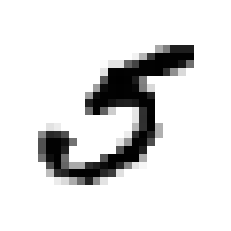

5.0


In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()
print(y[36000])

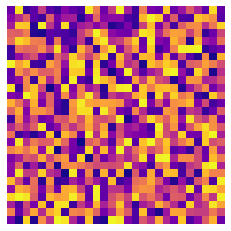

In [3]:
import random
import numpy as np
arr = np.array([random.randrange(0, 255) for iter in range(784)])
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
arr = arr.reshape(28,28)
plt.imshow(arr, cmap = plt.get_cmap("plasma")) #https://matplotlib.org/gallery/color/colormap_reference.html
plt.axis("off")
plt.show()

In [4]:
#test set is last 10000 images.
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]
#shuffle the training dataset to guarantee all cross-validation folds are similar.
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### 1. Training a Binary Classifier

In [5]:
#picture is number 5 or not
#target vector -> true for 5s, False for others
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)


# Stochastic Gradient Descent(SGD) classifier
# it deals with very large datasets efficiently.. deals with training instances independently, one at a time.
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42) # random_state is used for reproducing the same results
sgd_clf.fit(X_train, y_train_5)
print(sgd_clf.predict([some_digit]))


[ True]


### 2. Performance measure for Binary Classifier

In [6]:
#Implementing Cross vallidation of your own.
#to have better control over the process.

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits =3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))
#StratifiedKFold class performs stratified sampling to produce folds that contain representative ratio of each class.
#Anyways we should continnue with cross_val_score()

0.9643
0.96915
0.93435


In [7]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(sgd_clf, X_train, y_train_5, cv =3, scoring = "accuracy")) 
# Scoring should be accuracy instead of mean squared error in classification problems

[0.9643  0.96915 0.93435]


###### why we dont use cross_validation in these cases?
Because it is a skewed dataset (when some classes are much more frequent than others) ... Even if we give all false for 5 it will be 90% accurate.
#### Confusion Matrix

In [8]:
#cross_val_predict - Returns k-fold cross validation and returns predictions made on each validation set instead of score.
from sklearn.model_selection import cross_val_predict
y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
# we get a clean prediction for each instance in the dataset.
# clean prediction - model didn't saw that data during training.
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train_5, y_train_predict)) #actual values, predicted values.
print(confusion_matrix(y_train_5, y_train_5))

[[52730  1849]
 [  795  4626]]
[[54579     0]
 [    0  5421]]


- Each row represents actual class, while each columns represents predicted class.
- first row contains "False" of y_train_5, and first column contains "False" of y_train_predict.
- [[TN, FP], [FN, TP]]

##### Precision = TP / (TP+FP)
- Would fail if classifier predicts 1 positive which turns out to be TP.
- high precision -> full confidence in the true prediction

##### Recall = TP / (TP+FN)
- Sensetivity or True Positive Rate(TPR)
- Ratio of positive instances correctly detected by the classifier
- High recall -> some false alarms are fine, but false negatives should be minimized.

##### F1 = 2 * Precision*Recall / (Precision+Recall)
- Harmonic mean of both the values
- F1 value will be high only if both the values are high

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(precision_score(y_train_5, y_train_predict))
print(recall_score(y_train_5, y_train_predict))
#combine both of them
print(f1_score(y_train_5,y_train_predict))

0.7144401544401544
0.8533480907581626
0.7777404169468729


#### Precision/Recall Tradeoff
In some cases only one of these component is important, other is not ... Increasing precision reduces recall and vice-versa
##### Decision score 
- computed on basis of decision  function, True if the score crosses the threshold.(Decision Threshold)
- Low decision threshold -> High Recall
- High decision threshold -> High Precision

In [10]:
#Decision score for single instance
y_scores = sgd_clf.decision_function([some_digit])
print("Decision score for single instance", y_scores)
# Get precision scores for all instances using cross_val_predict, decision_function method
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

Decision score for single instance [1759.63733982]


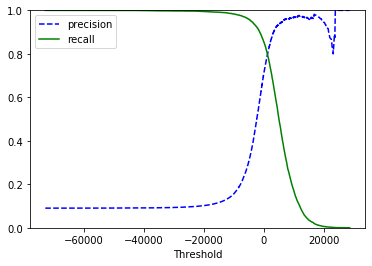

In [11]:
# precision_recall_curve() -> calculate precision and recall for all possible threshold.
from sklearn.metrics import precision_recall_curve
precision, recall, threshold = precision_recall_curve(y_train_5, y_scores)
def plot_precision_recall_vs_threshold(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "b--", label="precision")
    plt.plot(threshold, recall[:-1], "g-", label="recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precision, recall, threshold)
plt.show()

- why precision curve is bumpy?

suppose a list of images with increasing order of decision threshold, 8 7 3 9 5 2 2 5 6 5 5 5. Generally it should increase, but if we shift the threshold from 5th to 6th image, FP will remain same, while TP decreases resulting in decreased precision. 

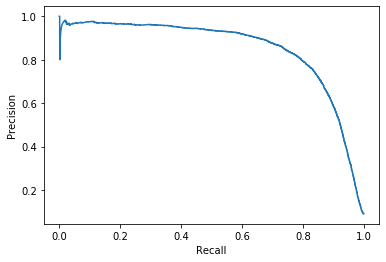

In [12]:
# now we can select threshold value that gives the best precision/recall tradeoff.
# we can also make a precision vs recall curve to get more clear vision
def plot_recall_vs_precision(recall, precision):
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
plot_recall_vs_precision(recall, precision)
plt.show()

###### How data scientists talk
- Client : "let's reach 99% precision."
- Me : "At what Recall?"

### 3. The ROC Curve (Receiver Operating Characteristic)
- False Positive Rate vs Recall
- FPR vs TPR 

##### False Positive rate = FP/(FP+TN)
##### Specificity = TN/(FP+TN)
- Also known as True Negative Rate
- FPR = 1- Specificity

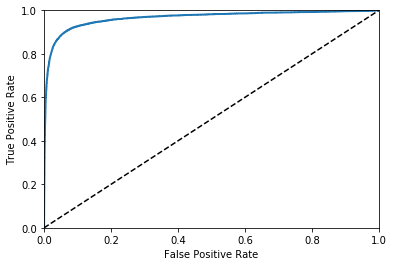

In [13]:
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_train_5, y_scores) #Actual instance, their decision score
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth = 2, label=label)
    plt.plot([0,1],[0,1],"k--")
    plt.axis([0,1,0,1]) # axis has 4 parameters xmin, xmax, ymin, ymax
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

##### Higher the Recall -> more False Positive the classifier produces.
- Dotted line represents the ROC curve of a purely random classifier.
- A good classifier stays far away from the line (towards the top-left corner)

In [14]:
# One way to compare classifiers is to meassure AUC -> Area Under Curve.
# perfect classifier -> AUC = 1
# purely random classifier -> AUC = 0.5
from sklearn.metrics import roc_auc_score
print("AUC Score-", roc_auc_score(y_train_5, y_scores))

AUC Score- 0.9653908422167382


##### When to use ROC curve and when to use Precision/Recall curve?
- Prefer PR Curve.
    - Positive Class is rare.
    - We care more about false positives than false negative.
    - For example : in previous case ROC curve is giving high score but from PR curve we know that there is room for improvement.
- Prefer ROC curve.
    - Equal positive and negative instances.
    
- Perfect classifier -> True positive rate was 1 (FN=0), when False Positive rate was 0 (FP=0), Hence AUC=1.
- But in case of skewed datasets like the one we are using, Even when number of FP is high the ratio remains low because TN>>FP.
- Purely random classifier TPR = FPR, TP/(TP+FN) = FP(FP+TN)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


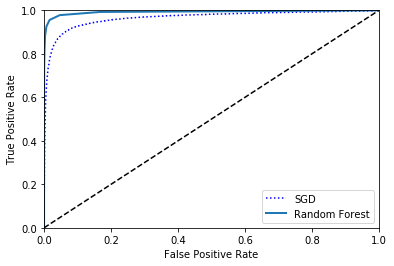

In [15]:
# Comparision of random forest and sgd classifier via ROC curve and AUC score.
# RandomForestClassifier doesn't have decision_function() it has predict_proba() method.(Scikit-learn classifiers have one or another)
# predict_proba() -> array containing row per instance, column per class
# i.e what is the probability that a particular instance belong to a particular class.
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method = "predict_proba")
# 0th column -> probability of data to give false.
# 1st column -> probability of data to give true.
# To obtain scores from predict_proba() lets pick up the probability of an instance to be true.
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)
# Plot ROC curve and compare
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")
plt.show()

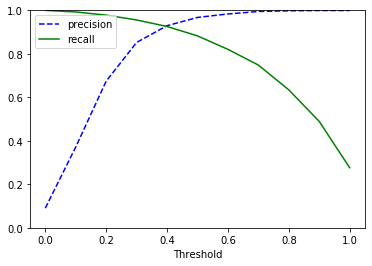

AUC score- 0.9926235875604891


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Precision score- 0.98342175066313
Recall score- 0.8206972883231876


In [16]:
# Random Forest works best
precision, recall, threshold = precision_recall_curve(y_train_5, y_scores_forest)
plot_precision_recall_vs_threshold(precision, recall, threshold)
plt.show()
# AUC score
print("AUC score-",roc_auc_score(y_train_5, y_scores_forest))
y_train_predict_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
# Precision score
print("Precision score-",precision_score(y_train_5, y_train_predict_forest))
# Recall score
print("Recall score-",recall_score(y_train_5, y_train_predict_forest))

- For setting custom Threshold, on the basis of PR threshold curve
    - y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method = "predict_proba")
    - y_scores_forest = y_probas_forest[:, 1]
    - y_train_predict_forest = (y_scores_forest > 0.4)

#### How to train binary classifiers? (summary)
- Choose the appropriate metric for your task.
- Evaluate using cross validation.
- Select the precision/recall tradeoff that fits your need.
- Compare various models using ROC curves and AUC scores.

### 4. Multi-Class Classification
- Multi Class or multinomial classifier can distinguish between more than two classes.
- Some algo such as Random Forest Classifiers or naive Bayes classifiers are capable of handling multiple classes.
- Others such as SVM classifier or Linear classifier are strictly binary classifier.

##### There are many strategies to perform multiclass classification using multiple binary classifiers.
- ##### One vs One (OvO) strategy
    - Train a binary classifier on every pair of digits and keep and run it through all the classifiers to see which class wins most number of duels.
    - ###### Disadvantage : 
        - For N classifiers we need to train N*(N-1)/2 classifiers.
        - For most binay classifier OvO is not preferred.
    - ###### Advantages :
        - Classifier only needs to be trained on part of the training set for the two classes.
        - Some Algo (eg- SVM Classifier) scale poorly with size of training set. So, OvO can solve the problem.
- ##### One vs All (OvA) strategy
    - Train N binary classifier, and for a single data compare decision score of each and every classifier. Highest win.\
    - Used on most of the binary classifiers.
    
Scikit Learn detects when we try to use binary classifier for multiclass and automatically runs OvA. OvO in case of SVM.

In [17]:
sgd_clf.fit(X_train, y_train)
print("Prediction -",sgd_clf.predict([some_digit]))
# 10 classifiers are trained to give predictions for each possibility
# The decision function will now give array of 10 decision scores, maximum of which will be selected.
some_digit_scores = sgd_clf.decision_function([some_digit])
print("Decision Scores -",some_digit_scores)
# we can select the argument which has maximum decision score
print("Argument with maximum decision score -",np.argmax(some_digit_scores))
# We can see the different classes for which the classifiers are trained.
print("List of classes -",sgd_clf.classes_)
# Finally we can obtain the predicted class using argument for which we obtained maximum decision score
print("Class with maximum probability -",sgd_clf.classes_[np.argmax(some_digit_scores)])

Prediction - [5.]
Decision Scores - [[ -5261.15740152 -24395.30283283  -7567.5580189   -3159.93481056
  -17266.33941917    708.52154798 -27183.97826583 -14530.27538155
  -15296.32418256 -11392.24228234]]
Argument with maximum decision score - 5
List of classes - [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Class with maximum probability - 5.0


In [18]:
# sklearn has classes for OneVsOneClassifier and OneVsRestClassifier.
# Create an instance and pass a binary classifier to its constructor.
from sklearn.multiclass import OneVsOneClassifier
# Pass the classifier to the constructor and fit the training data
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))
# Total N*(N-1)/2 estimators(classifiers) are trained
print(len(ovo_clf.estimators_))

[5.]
45


In [19]:
# Training a random forest classifier
# Random forest doesn't need ovo or ova because it supports multi-class classification.
forest_clf.fit(X_train,y_train)
print(forest_clf.predict([some_digit]))
#predict_proba can be used to see the probability of each and every digit
print(forest_clf.predict_proba([some_digit]))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[5.]
[[0.1 0.  0.  0.  0.  0.9 0.  0.  0.  0. ]]


In [20]:
# Let's measure accuracy of sgd_classifier 
print("Scores for sgd_classifier -",cross_val_score(sgd_clf, X_train, y_train, scoring="accuracy"))
# We can increase the accuracy by simply scaling the data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # Keep a habit of passing X_train.astype(np.float64)
print("Scores for sgd_classifier after scaling -",cross_val_score(sgd_clf, X_train_scaled, y_train, scoring="accuracy"))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Scores for sgd_classifier - [0.87572486 0.83274164 0.86983047]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Scores for sgd_classifier after scaling - [0.90311938 0.9059453  0.9006851 ]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


### 5. Error Analysis
- Error Analysis is a way to improve the performance of our model.

#### Confusion Matrix

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[[5606    0   15    7   10   41   38    6  199    1]
 [   1 6435   41   24    3   41    5   10  172   10]
 [  29   25 5245  100   77   22   71   38  342    9]
 [  25   15  109 5272    1  221   29   38  354   67]
 [  15   14   44   11 5274    9   39   18  274  144]
 [  27   16   27  161   56 4519   81   15  453   66]
 [  30   20   45    3   42   90 5562    8  118    0]
 [  21   16   56   27   50   13    4 5716  144  218]
 [  17   69   40   98    6  116   32    8 5418   47]
 [  21   24   33   64  127   38    1  186  307 5148]]
GRAPHICAL REPRESENTATION


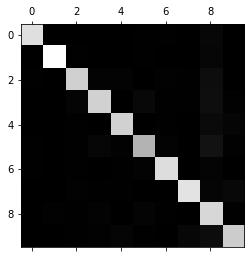

In [21]:
# obtain predictions on training set using cross_val_predict.
y_train_predict = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
# Row represents actual class and column represents predicted class.
conf_mx = confusion_matrix(y_train, y_train_predict)
print(conf_mx)
print("GRAPHICAL REPRESENTATION")
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

###### Points to notice :
- The block along diagonal which is darker requires more training or data.
- let's focus on plotting the error rather than plotting the TPs.
    - Normalise the values in confusion matrix by dividing by number of images in corresponding class.

[[5923]
 [6742]
 [5958]
 [6131]
 [5842]
 [5421]
 [5918]
 [6265]
 [5851]
 [5949]]


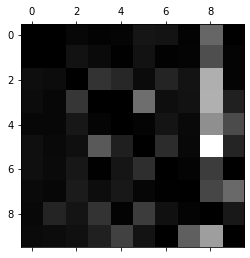

In [22]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
print(row_sums)
norm_conf_mx = conf_mx/row_sums
#fill the diagonal with zero to plot only the errors.
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

###### Observations:
- rows -> actual class, column -> predicted class
- Many images got misclassified as 8,9.
- Eforts should be made to improve the classification on 8 and 9.
    - New features such as "closed loop" can be used to distinguish between two digits.
    - Can preprocess the image to make some feature stand out more(eg - closed loop), using OpenCV, pillow or scikit-image.
- Symmitrical misclassification (3 identified as 5 ~= 5 identified as 3) also exists.

###### Analysing individual errors:

In [23]:
# Understand this function ...

import matplotlib as mpl
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

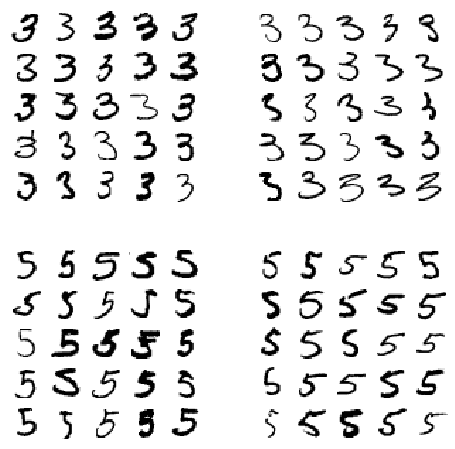

In [24]:
cls_a, cls_b = 3,5
X_aa = X_train[(y_train==cls_a) & (y_train_predict == cls_a)]
X_ab = X_train[(y_train==cls_a) & (y_train_predict == cls_b)]
X_ba = X_train[(y_train==cls_b) & (y_train_predict == cls_a)]
X_bb = X_train[(y_train==cls_b) & (y_train_predict == cls_b)]


plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

### 6. Multilabel Classification

- Sometimes we may want to predict multiple labels for our single instance.
- eg. if a selected instance is greater than 5?(1) and is it a odd number?(2)
- The systems that outputs **Multiple Binary Labels.**  


In [25]:
from sklearn.neighbors import KNeighborsClassifier
#Define two binary output labels that you want to predict
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
#K-Nearest Neighbors supports multilabel classification
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [26]:
knn_clf.predict([some_digit])
# 1. If a number is large. 2. If a number is odd. 

array([[False,  True]])

##### Evaluation of multilabel classifier:
- We can generate different metrics (eg - f1 score) for each of the output label and take out the average score.
- This can be done as follows:

In [27]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9773941008253076

- This method assumes that each and every output label is equally important.
- If we have many more instance of a label compared to other labels, then we should give more weight to classifier's F1 score on that label.
- This can be done by following line of code:
    f1_score(y_multilabel, y_train_knn_pred, average="weighted")

### 7. Multioutput Classification
- Also known as Multioutput-Multiclass Classification
- It is just generalization of multilabel classifiers, where **each label can be non-Binary or Multiclass**.


##### Great Example ( Image noise remover ):
- Classifier's output is multilabel (one label per pixel)
- Each label can have multiple values (0-255)

Text(0.5, 1.0, 'Without noise')

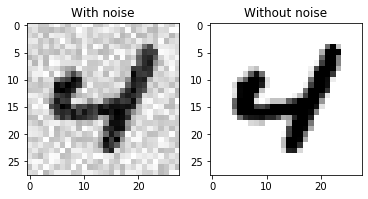

In [28]:
# Generate noise using numpy randint.
from numpy import random
noise_train = random.randint(0, 100, size=(len(X_train), 784))
noise_test = random.randint(0, 100, size=(len(X_test), 784))
# Add noise to data
X_train_mod = X_train+noise_train
X_test_mod = X_test+noise_test
y_train_mod = X_train
y_test_mod = X_test
# sample from noisy set and test set.
some_index = 36000
fig,a =  plt.subplots(1,2)
some_digit = X_train_mod[some_index]
some_digit_image = some_digit.reshape(28,28)
a[0].imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
a[0].set_title('With noise')
some_digit = y_train_mod[some_index]
some_digit_image = some_digit.reshape(28,28)
a[1].imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
a[1].set_title('Without noise')

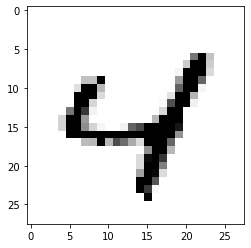

In [31]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_train_mod[some_index]])
clean_digit_image = clean_digit.reshape(28,28)
plt.imshow(clean_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")

###### The line between classification and regression are sometimes blurry.
    - ex. predicting pixel intensity is more akin to regression than to classification.

- Multioutput systems are not limited to clssification task.We can even create a system thatoutputs multiple labels per instance, including both class labels and value labels.